# Conv1D + LSTM + Linear + LinearX, LinearY

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# nuscenes-devkit tools 
!pip install nuscenes-devkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# math
import numpy as np
import math

# torch
import torch
import torch.nn as nn
from torch.autograd import Variable

# generic
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import gc

# nuscenes
import nuscenes
from nuscenes.eval.prediction import metrics
from nuscenes.prediction import PredictHelper

# plot
import matplotlib.pyplot as plt

## 2. Using GPU

In [ ]:
# Using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

You can import the file "np_trajectory_data_22_with_VAR.npy" from [Link](https://drive.google.com/drive/folders/118Z18sWEg4CqHAhFcYmDqXvDj2qk4YtI?usp=sharing), it's the same with "trajectory" data in "DL-Project.ipynb" at code 3.3. Just for testing convenience 

`trajectory = get_trajectories(trajectory_data, uni_instance_ids)`


`np.save('np_trajectory_data_22_with_VAR.npy', trajectory)
`

In [ ]:
trajectory = np.load("/content/drive/MyDrive/DL_nuScenes/np_trajectory_data_22_with_VAR.npy", allow_pickle=True)

In [ ]:
trajectory.shape

(17503,)

### 3 Spliting Datasets


- Spliting the dataset:
  - 60% as training data
  - 20% as validation data
  - 20% as test data

In [ ]:
train_data = trajectory[0:int(len(trajectory) * 0.6)]
val_data = trajectory[int(len(trajectory) * 0.6): int(len(trajectory) * 0.8)]
test_data = trajectory[int(len(trajectory) * 0.8):]

## 4. Utils
- Our tools



In [ ]:
def sliding_window(data, SEQ_LENGTH):
    """using sliding window divide the single trajectory into several train samples
    """
    origin_xs = []
    expected_xs = []
    for i in range(len(data) - SEQ_LENGTH - 11):
        origin_x = data[i: (i + SEQ_LENGTH)]
        expected_x = data[(i + SEQ_LENGTH): (i + SEQ_LENGTH + 12)]
        origin_xs.append(origin_x)
        expected_xs.append(expected_x)
    return np.array(origin_xs), np.array(expected_xs)


def reshape_data_1(x):
    """convert the data to tensor and reshape
    """
    X = torch.tensor(np.array(x), dtype=torch.float32)
    X = torch.reshape(X, (X.shape[0], 1))
    return X


def reshape_data_2(x):
    """convert the data to tensor and reshape
    """
    X = torch.tensor(np.array(x), dtype=torch.float32)
    X = torch.reshape(X, (X.shape[0], X.shape[1], 1))
    return X


def costruct_train_dataset(trajectory, SEQ_LENGTH):
    """contruct the train dataset
    """
    tra = []
    for t in trajectory:
        tra.append(t[2:7])

    # scaling data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    xyvar = scaler.fit_transform(tra)

    # get x, y, speed, accleration, heading rate
    x, y, v, a, r = xyvar[:, 0], xyvar[:,
                                       1], xyvar[:, 2], xyvar[:, 3], xyvar[:, 4]

    # using sliding_window to get the train data
    x, exp_x = sliding_window(x, SEQ_LENGTH)
    y, exp_y = sliding_window(y, SEQ_LENGTH)
    v, exp_v = sliding_window(v, SEQ_LENGTH)
    a, exp_a = sliding_window(a, SEQ_LENGTH)
    r, exp_r = sliding_window(r, SEQ_LENGTH)

    # reshape x, y, ground x and y
    dataX = reshape_data_2(x)
    dataY = reshape_data_2(y)
    exp_x = reshape_data_2(exp_x)
    exp_y = reshape_data_2(exp_y)

    # reshape speed, accleration, heading rate
    dataV = reshape_data_2(v)
    dataA = reshape_data_2(a)
    dataR = reshape_data_2(r)
    exp_v = reshape_data_2(exp_v)
    exp_a = reshape_data_2(exp_a)
    exp_r = reshape_data_2(exp_r)

    return dataX, dataY, exp_x, exp_y, dataV, exp_v, dataA, exp_a, dataR, exp_r


def clean_nan(tra):
    """ Remove nan point
    """
    tra_new = []
    for t in tra:
        if math.isnan(t[4]) or math.isnan(t[5]) or math.isnan(t[6]):
            continue
        else:
            tra_new.append(t)
    return tra_new


def traj2modes(trajs):
    """Convert data type to numpy.array
    """
    return np.array([trajs])

### 5.6 Conv1D + LSTM + Linear + LinearX, LinearY
- Keep the LSTM to extract the time sequence information.
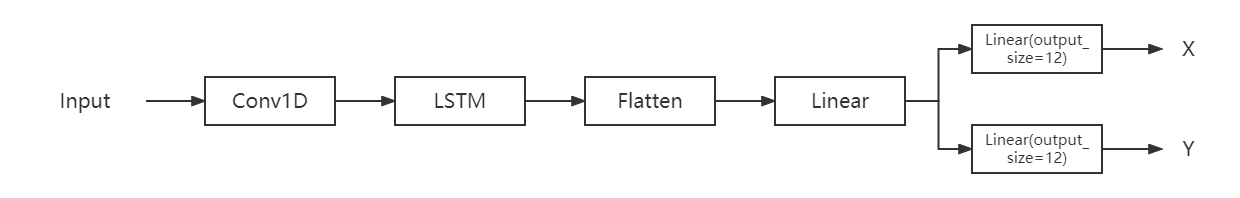

In [ ]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        '''
        data: [batch, sequence, data]
        '''
        super(Model, self).__init__()
        # model size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # layers
        self.cnn = nn.Conv1d(5, 32, 3)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # dense
        self.fc0 = nn.Linear(6 * 32, 24)
        self.fcX = nn.Linear(24, 12)
        self.fcY = nn.Linear(24, 12)
        

    def forward(self, data):
        ''' 
        data: [b, 8, 5]
        '''
        # #[1, b, 64]
        h_0 = Variable(torch.zeros(self.num_layers,
                       data.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers,
                       data.size(0), self.hidden_size)).to(device)

        # Conv1d
        # [b, 8, 5] -> [b, 5, 8]
        data = torch.permute(data, (0, 2, 1))
        # [b, 5, 8] -> [b, 32, 6]
        data = self.cnn(data)


        # [b, 32, 6] -> [b, 6, 32]
        data = torch.permute(data, (0, 2, 1))
        # LSTM
        # [b, 6, 32] -> [b, 6, 32]
        out, (_, _) = self.lstm(data, (h_0, c_0))

        # Dense
        # flatten [b, 6, 32] -> [b, 6*32]
        out = torch.flatten(out, start_dim=1)
        # [b, 6*32] -> [b, 24]
        out = self.fc0(out)

        # output
        # [b, 24] -> [b, 12]
        out_x = self.fcX(out)
        # [b, 24] -> [b, 12]
        out_y = self.fcY(out)
        # [b, 12] -> [b, 12, 1]
        out_x = torch.reshape(out_x, (out_x.shape[0], out_x.shape[1], 1))
        # [b, 12] -> [b, 12, 1]
        out_y = torch.reshape(out_y, (out_y.shape[0], out_y.shape[1], 1))

        return out_x, out_y

## 6.Training

### 6.1 Train Function
- In order to crop the data into the same shape and expand the 
training set data，we divide the single trajectory into several samples
using silding window. 

- We chose the five features contain target x, y, speed, 
acceleration and heading rate as input feed to the model, 
and get the predicted (x, y) as output to Propagate loss.


In [ ]:
def train_func(trajectory, model, SEQ_LENGTH, epoch, optimizer, loss_func):
    model.train()
    Interval = 200
    train_loss = 0
    train_loss_in_batches = []
    interval_loss = 0
    i = 0

    for tra in trajectory:
        # clean nan
        tra = clean_nan(tra)

        # remove short trajectories
        if len(tra) < 20 or tra[0][-1] == 0:
            continue

        # zero grad
        optimizer.zero_grad()

        # get trajectories
        x, y, ex, ey, v, ev, a, ea, r, er = costruct_train_dataset(
            tra, SEQ_LENGTH)

        # cat train data
        cat_data = torch.cat([x, y, v, a, r], dim=2)
        cat_data = cat_data.to(device)

        # lstm model
        predicted_output_x, predicted_output_y = model(cat_data)

        # loss
        ex, ey = ex.to(device), ey.to(device)
        loss_x = loss_func(predicted_output_x, ex)
        loss_y = loss_func(predicted_output_y, ey)
        loss = loss_x + loss_y
        train_loss += loss
        interval_loss += loss

        # loss backward
        loss.backward()

        # optimizer
        optimizer.step()

        # train samples count
        i += 1

        # print loss
        if i % Interval == 0 and i > 0:
            print(
                f"| Epoch {epoch:3d} | {i:5d}/5400   batches | loss: {interval_loss / Interval:8.3f}")
            # whole losses
            train_loss_in_batches.append((interval_loss / Interval).cpu().data)
            interval_loss = 0

    return train_loss / len(trajectory), train_loss_in_batches


def val_func(trajectory, lstm, SEQ_LENGTH, epoch, loss_func):
    lstm.eval()
    cum_loss = 0
    length = len(trajectory)
    loss_in_batches = []

    with torch.no_grad():
        for tra in trajectory:
            # clean nan
            tra = clean_nan(tra)

            # remove short trajectories
            if len(tra) < 20 or tra[0][-1] == 0:
                length -= 1
                continue
            # get trajectories
            x, y, ex, ey, v, ev, a, ea, r, er = costruct_train_dataset(
                tra, SEQ_LENGTH)

            # cat val data
            cat_data = torch.cat([x, y, v, a, r], dim=2)
            cat_data = cat_data.to(device)

            # model
            predicted_output_x, predicted_output_y = lstm(cat_data)

            # loss
            ex, ey = ex.to(device), ey.to(device)
            loss_x = loss_func(predicted_output_x, ex)
            loss_y = loss_func(predicted_output_y, ey)
            cum_loss += (loss_x + loss_y)
            # print loss
    print(
        f'| Validation Epoch {epoch:3d} | Avg-Val Loss: {cum_loss / (length)}')

    return cum_loss / length

### 6.2 Model Instantiation
- The input shape is 5 which is (x, y, v, a, r)
- And data trained on GPU

In [ ]:
# cnn_lstm = Model(6, 32, 1)
cnn_lstm = Model(32, 32, 1)
cnn_lstm = cnn_lstm.to(device)
LEARNING_RATE = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

### 6.3 Train Model
- Trianing preocess with epoch = 3

In [ ]:
PREDICTED_LENGTH = 12
SEQ_LENGTH = 8
EPOCH = 6

t_loss_in_batches = []
t_loss = []
v_loss = []

for epoch in range(EPOCH):
    train_loss, train_loss_in_batches = train_func(
        train_data, cnn_lstm, SEQ_LENGTH, epoch, optimizer, loss_func)
    val_loss = val_func(val_data, cnn_lstm, SEQ_LENGTH, epoch, loss_func)
    t_loss.append(train_loss.item())
    t_loss_in_batches = np.append(t_loss_in_batches, train_loss_in_batches)
    v_loss.append(val_loss.item())

| Epoch   0 |   200/5400   batches | loss:    0.753
| Epoch   0 |   400/5400   batches | loss:    0.538
| Epoch   0 |   600/5400   batches | loss:    0.458
| Epoch   0 |   800/5400   batches | loss:    0.366
| Epoch   0 |  1000/5400   batches | loss:    0.388
| Epoch   0 |  1200/5400   batches | loss:    0.389
| Epoch   0 |  1400/5400   batches | loss:    0.359
| Epoch   0 |  1600/5400   batches | loss:    0.333
| Epoch   0 |  1800/5400   batches | loss:    0.341
| Epoch   0 |  2000/5400   batches | loss:    0.326
| Epoch   0 |  2200/5400   batches | loss:    0.323
| Epoch   0 |  2400/5400   batches | loss:    0.388
| Epoch   0 |  2600/5400   batches | loss:    0.330
| Epoch   0 |  2800/5400   batches | loss:    0.331
| Epoch   0 |  3000/5400   batches | loss:    0.339
| Epoch   0 |  3200/5400   batches | loss:    0.294
| Epoch   0 |  3400/5400   batches | loss:    0.277
| Epoch   0 |  3600/5400   batches | loss:    0.341
| Epoch   0 |  3800/5400   batches | loss:    0.271
| Epoch   0 

## 6.4 Plot Training Loss
- Plot the detailed train loss and the train-val loss with epochs.

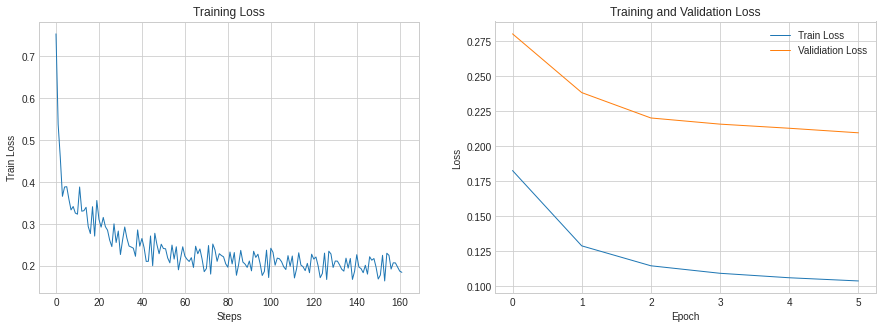

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

epovec = range(len(t_loss_in_batches))
plt.plot(epovec, t_loss_in_batches, linewidth=1)
# annotations:
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
# plt.show()

# plot_train_loss(t_loss_in_batches, plt)
plt.subplot(1, 2, 2)
# plt.figure(figsize=(5,5))
epovec = range(len(t_loss))
plt.plot(epovec, t_loss, epovec, v_loss, linewidth=1)
plt.legend(('Train Loss', 'Validiation Loss'))

# annotations:
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 7. Test

### 7.1 Test Function
- In test function, different from training process, we do not divide
the singe trajectory into different samples.
In contrast, we get the ground truth and predicted trajectories directly.
Then we use three matrics which called ADE, FDE and missRate to
evaluate the results.

In [ ]:
def test_func(model, trajectory, SEQ_LENGTH, PREDICTED_LENGTH):
    # get trajectories contrains x, y, (speed, acceleration, heading rate)
    traj_with_xyvar = []
    traj_with_xy = []
    for tra in trajectory:
        traj_with_xyvar.append(tra[2:7])
        traj_with_xy.append(tra[2:4])

    # scale the data
    # test data with x, y, speed, acceleration, heading rate
    scaler = MinMaxScaler(feature_range=(-1, 1))
    xyvar = scaler.fit_transform(traj_with_xyvar)

    # test data with x, y, speed, acceleration, heading rate
    scaler_new = MinMaxScaler(feature_range=(-1, 1))
    xy_new = scaler_new.fit_transform(traj_with_xy)

    # get the x, y, speed, acceleration, heading rate respectively, shape: [m, 1]
    x_s, y_s, v_s, a_s, r_s = xyvar[:, 0], xyvar[:,
                                                 1], xyvar[:, 2], xyvar[:, 3], xyvar[:, 4]

    # get the x, y ground truth of x, y
    # and speed, acceleration, heading rate as the test data to the model
    x, expected_x = [x_s[0:SEQ_LENGTH]
                     ], x_s[SEQ_LENGTH:SEQ_LENGTH + PREDICTED_LENGTH]
    y, expected_y = [y_s[0:SEQ_LENGTH]
                     ], y_s[SEQ_LENGTH:SEQ_LENGTH + PREDICTED_LENGTH]
    v = [v_s[0:SEQ_LENGTH]]
    a = [a_s[0:SEQ_LENGTH]]
    r = [r_s[0:SEQ_LENGTH]]

    original_x, original_y = x_s[:SEQ_LENGTH], y_s[:SEQ_LENGTH]  # [8, 1]

    # convert datat to tensor and change the shape, shape: [1, 8, 1]
    dataX, dataY = reshape_data_2(x), reshape_data_2(y)
    dataV = reshape_data_2(v)
    dataA = reshape_data_2(a)
    dataR = reshape_data_2(r)

    # return origin x, y and ground truth for plot
    # origin data
    original_x = reshape_data_1(original_x)
    original_y = reshape_data_1(original_y)  # [8 ,1]
    original_xy = torch.cat([original_x, original_y], dim=1)  # [8, 2]
    data_original = scaler_new.inverse_transform(original_xy)  # [8, 2]
    # ground truth
    expected_x = reshape_data_1(expected_x)
    expected_y = reshape_data_1(expected_y)  # [m, 10, 1]
    ground_truth_xy = torch.cat([expected_x, expected_y], dim=1)  # [10, 2]
    data_expected = scaler_new.inverse_transform(ground_truth_xy)  # [10, 2]

    # eval
    model.eval()

    with torch.no_grad():
        # cat trjectories data with x, y, speed, acceleration, heading rate to test
        cat_data = torch.cat(
            [dataX, dataY, dataV, dataA, dataR], dim=2)  # [m, 8, 5]
        cat_data = cat_data.to(device)
        # test model
        output_x, output_y = model(cat_data)  # [m, 10, 1]

        # concat output
        output = torch.cat([output_x, output_y],
                           dim=2).cpu().data  # [m, 10, 2]
        output = torch.reshape(output, [output.shape[1], output.shape[2]])

        # predicted data
        predicted_data = scaler_new.inverse_transform(output)  # [m, 10, 2]

    return predicted_data, data_expected, data_original

### 7.2 Metrics
- ADE, FDE and missRate

In [ ]:
p_one_mode = np.array([[1.]])


def Metrics(lstm, test_data, SEQ_LENGTH, PREDICTED_LENGTH):
    # initialization
    avg_ade = 0
    avg_fde = 0
    avg_missRate = 0
    length = len(test_data)
    plot_data = []

    # get predicted, origin and ground truth x, y
    for tra in tqdm(test_data):
        # clean nan
        tra = clean_nan(tra)

        # remove short trajectories
        if len(tra) < 20:
            length -= 1
            continue
        if tra[0][-1] == 0:
            continue

        # get predicted, origin and ground truth x, y from test function(model)
        predicted_data, data_expected, data_original = test_func(
            lstm, tra, SEQ_LENGTH, PREDICTED_LENGTH)

        # collect trajectories data
        plot_data.append([predicted_data, data_expected, data_original])

        # convert the data to the nuscenes ade, fde, missRate function format
        modes = data_expected.shape[0]
        x_one_mode, y_one_mode = traj2modes(
            predicted_data), traj2modes(data_expected)

        # compute ade, fde and missRate with nuscenes metrics
        ade = metrics.min_ade_k(x_one_mode, y_one_mode, p_one_mode)
        fde = metrics.min_fde_k(x_one_mode, y_one_mode, p_one_mode)
        missRate = metrics.miss_rate_top_k(
            x_one_mode, y_one_mode, p_one_mode, 2)

        # avg_ade, avg_fde and avg_missRate
        avg_ade += ade
        avg_fde += fde
        avg_missRate += missRate

    avg_ade = avg_ade / length
    avg_fde = avg_fde / length
    avg_missRate = 1 - avg_missRate / length
    print()
    print("avg_ade:", avg_ade[0][0])
    print("avg_fde:", avg_fde[0][0])
    print("avg_missRate:", avg_missRate[0][0])

    return plot_data, avg_ade, avg_fde, avg_missRate

In [ ]:
plot_data, avg_ade, avg_fde, avg_missRate = Metrics(
    cnn_lstm, test_data, SEQ_LENGTH, PREDICTED_LENGTH)

  0%|          | 0/3501 [00:00<?, ?it/s]


avg_ade: 1.155114251861771
avg_fde: 2.1056027991212427
avg_missRate: 0.7618639222412807
